In [1]:
# Imports
from google.colab import drive
drive.mount('/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

Mounted at /drive


# Part 1 - NFC East Tournament

In [ ]:
X = np.array([[1,-1,0,0],[0,0,1,-1],[-1,0,0,1],[0,1,-1,0],[1,0,-1,0],[0,-1,0,1]])
X

array([[ 1, -1,  0,  0],
       [ 0,  0,  1, -1],
       [-1,  0,  0,  1],
       [ 0,  1, -1,  0],
       [ 1,  0, -1,  0],
       [ 0, -1,  0,  1]])

In [ ]:
# Game outcomes
# Game 1: Eagles (H) vs Cowboys (A): 28-23 = 5
# Game 2: Giants (H) vs Commanders (A): 14-7 = 7
# Game 3: Commanders (H) vs Eagles (A): 31-38 = -7
# Game 4: Cowboys (H) vs Giants (A): 49-17 = 32
# Game 5: Eagles (H) vs Giants (A): 22-16 = 6
# Game 6: Commanders (H) vs Cowboys (A): 26-6 = 20
y = np.array([5,7,-7,32,6,20]).reshape((-1,1)) # force 6 x 1 matrix
y

array([[ 5],
       [ 7],
       [-7],
       [32],
       [ 6],
       [20]])

## Try to Estimate OLS Team Strengths
$$\boldsymbol{\hat{\theta}} = (\mathbf{X}^\top \mathbf{X})^{-1}\mathbf{X}^\top \mathbf{y}$$

In [ ]:
XtX = X.T @ X
theta_hat = np.linalg.inv(XtX) @ X.T @ y

LinAlgError: Singular matrix

## What went wrong??

In [ ]:
XtX

array([[ 3, -1, -1, -1],
       [-1,  3, -1, -1],
       [-1, -1,  3, -1],
       [-1, -1, -1,  3]])

In [ ]:
X

array([[ 1, -1,  0,  0],
       [ 0,  0,  1, -1],
       [-1,  0,  0,  1],
       [ 0,  1, -1,  0],
       [ 1,  0, -1,  0],
       [ 0, -1,  0,  1]])

### Detecting Perfect Multicollinearity

In [ ]:
# 1. If determinant = 0 ==> inverse of XtX does not exist ==> multicollinearity
np.linalg.det(XtX)

0.0

In [ ]:
# 2. If condition number is a very large number ==> Likely multicollinearity
np.linalg.cond(XtX)

9007199254740994.0

In [ ]:
# 3. If there is a zero eigenvalue ==> multicollinearity
np.linalg.eigvals(XtX)

array([ 4.00000000e+00, -1.11022302e-16,  4.00000000e+00,  4.00000000e+00])

In [22]:
# 4. If VIF is infinity ==> Multicollinearity
def VIF(X):
  # Computes variance inflation factor
  df_VIF = pd.DataFrame()
  df_VIF['Feature'] = X.columns
  df_VIF["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

  return df_VIF

VIF(pd.DataFrame(X))

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,0,inf
1,1,inf
2,2,inf
3,3,inf
4,4,inf
5,5,inf
6,6,inf
7,7,inf
8,8,inf
9,9,inf


- All methods for detecting perfect multicollinearity above point to the same conclusion.
- Yes, there is perfect multicollinearity.

## Solving the Problem to Get Unique Solution
1. Set an arbitrary team's coefficient equal to some constant value $k$ (e.g., $\theta_i = 0$). This team becomes the **reference team**.
2. Set the sum of all team coefficients equal to zero. $$\sum_j \theta_j = 0$$
Now, the **reference team** is the "League Average."


In [2]:
def ols_linear_constraint1_general(X: np.ndarray, y: np.ndarray, k: float) -> np.ndarray:
  """
  This is the more general form of our first constraint where we set the final team's
  coefficient to a constant value, k.

  Parameters:
    X: Original design matrix of team matchups
    y: Vector of score differentials
    k: Constant value to set final team's coefficient to

  Returns:
    Numpy array with all estimated coefficients concatenated with the last team's coefficient value, k.
  """

  # Create new target vector (moving final column in X x k to left side of equation)
  y_star = y - np.array(X[:,-1]*k).reshape((-1,1))

  # Create new design matrix with final column removed
  X_star = X[:,:-1]

  # Proceed with typical formula for OLS solution
  XtX_star = X_star.T @ X_star
  theta_hat_star = np.linalg.inv(XtX_star) @ X_star.T @ y_star

  # Concatenate final team's constrained value, k, to estimated coefficients
  theta_hat = np.concatenate((theta_hat_star, np.array(k).reshape(-1,1)))

  return theta_hat

In [3]:
def ols_linear_constraint1(X: np.ndarray,y: np.ndarray) -> np.ndarray:
  """
  This is the special case of the function above where k = 0. In this special
  case, we can simply remove the final column of X and keep everything else
  as normal.

  Parameters:
    X: Original design matrix of team matchups
    y: Vector of score differentials

  Returns:
    Numpy array with all estimated coefficients concatenated with a 0 for the
    final team's constrained coefficient.
  """
  # Create new design matrix with final column removed
  X = X[:,:-1]

  # Proceed with typical formula for OLS solution
  XtX = X.T @ X
  theta_hat = np.linalg.inv(XtX) @ X.T @ y

  # Concatenate final team's constrained value, k=0, to estimated coefficients
  theta_hat = np.concatenate((theta_hat, np.array(0).reshape((-1,1))))

  return theta_hat


In [ ]:
# General Outputs
print("k = 0")
theta_hat_general_0 = ols_linear_constraint1_general(X=X, y=y, k=0)
print(theta_hat_general_0)
print("\n")
print("k = 10")
theta_hat_general_10 = ols_linear_constraint1_general(X=X, y=y, k=10)
print(theta_hat_general_10)

k = 0
[[ 3.  ]
 [ 0.25]
 [-9.25]
 [ 0.  ]]


k = 10
[[13.  ]
 [10.25]
 [ 0.75]
 [10.  ]]


In [ ]:
# Special Case of k = 0
print("k = 0")
theta_hat_0 = ols_linear_constraint1(X=X, y=y)
print(theta_hat_0)

k = 0
[[ 3.  ]
 [ 0.25]
 [-9.25]
 [ 0.  ]]


- Notice that this is the exact same output as the first output above

## How do we make predictions (in-sample/training at this point)?

$$\hat{\mathbf{y}} = \mathbf{X}\hat{\boldsymbol{\theta}}$$

In [ ]:
y_pred = X @ theta_hat_0
y_pred

array([[ 2.75],
       [-9.25],
       [-3.  ],
       [ 9.5 ],
       [12.25],
       [-0.25]])

## Compute residuals

In [ ]:
res = y - y_pred
res

array([[ 2.25],
       [16.25],
       [-4.  ],
       [22.5 ],
       [-6.25],
       [20.25]])

### Alternatively, we could also find a $W$ matrix that encodes this constraint.
$$W =
\begin{pmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 \\
0 & 0 & 0
\end{pmatrix}$$

In [ ]:
W = np.identity(4)[:,:-1]
W

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

In [ ]:
X_star = X @ W
X_star

array([[ 1., -1.,  0.],
       [ 0.,  0.,  1.],
       [-1.,  0.,  0.],
       [ 0.,  1., -1.],
       [ 1.,  0., -1.],
       [ 0., -1.,  0.]])

In [ ]:
theta_hat_W_0 = np.linalg.inv(X_star.T @ X_star) @ X_star.T @ y
theta_hat_W_0

array([[ 3.  ],
       [ 0.25],
       [-9.25]])

- We get the same result for the first three teams. We now would just need to concatenate our forced coefficient constraint for the last time ($\theta_4 = 0$).

### We can obtain the same results by inputing $X^* = XW$ into statsmodels

In [ ]:
model1 = sm.OLS(endog=y, exog=X_star).fit()
xnames = ['Eagles', 'Cowboys','Giants'] # add in names of columns in design matrix
print(model1.summary(xname=xnames))

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.216
Model:                            OLS   Adj. R-squared (uncentered):             -0.567
Method:                 Least Squares   F-statistic:                             0.2761
Date:                Thu, 06 Feb 2025   Prob (F-statistic):                       0.841
Time:                        02:28:28   Log-Likelihood:                         -24.508
No. Observations:                   6   AIC:                                      55.02
Df Residuals:                       3   BIC:                                      54.39
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

- Don't pay too much attention to the actual statistics here, because there are only 6 data points.
- Do pay attention to the coefficient estimates for the first three teams. These exactly match what we've seen above.

### Let's set up our second type of constraint ($\sum_i \theta_i = 0$)
As mentioned in lecture, it's easiest to encode this constraint with a $W$ matrix.
$$
W = \begin{pmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 \\
-1 & -1 & -1
\end{pmatrix}
$$

In [ ]:
W = np.identity(4)[:,:-1]
W[-1,:] = -1 # assign -1 to each value in the last row
W

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [-1., -1., -1.]])

- Now follow the same procedure as above. We will do this ourselves just using `numpy` and `statsmodels`.

In [ ]:
# Numpy
X_star = X @ W
theta_hat_W_1 = np.linalg.inv(X_star.T @ X_star) @ X_star.T @ y

theta_hat_W_1

array([[ 4.5 ],
       [ 1.75],
       [-7.75]])

In [ ]:
# Constrained final coefficient
theta_final = -1*theta_hat_W_1.sum()
theta_final # 1.5

1.4999999999999982

In [ ]:
# Statsmodels
model2 = sm.OLS(endog=y, exog=X @ W).fit()
xnames = ['Eagles','Cowboys','Giants']
print(model2.summary(xname=xnames))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.216
Model:                            OLS   Adj. R-squared (uncentered):             -0.567
Method:                 Least Squares   F-statistic:                             0.2761
Date:                Thu, 06 Feb 2025   Prob (F-statistic):                       0.841
Time:                        02:28:28   Log-Likelihood:                         -24.508
No. Observations:                   6   AIC:                                      55.02
Df Residuals:                       3   BIC:                                      54.39
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


- Again, everything matches.

#### If you wanted to create a function that's more flexible in terms of

In [4]:
def ols_linear_constraint2(X: np.ndarray,
                           y: np.ndarray,
                           W: np.ndarray,
                           insert_idx: int = None) -> np.ndarray:
  """
  This is an implementation of our second contrains where the sum of the
  coefficients equals 0. This also implies that the average of the coefficients
  equals 0.

  Parameters:
    X: Original design matrix of team matchups
    y: Vector of score differentials
    W: Matrix encoding our coefficient constraints
    insert_idx: Integer of the index where the constrained value should be placed

  Returns:
    Numpy array with all estimated coefficients concatenated with a final constrained
    coefficient value of theta_p = -theta_1 - theta_2 - ... - theta_(p-1) for the
    final team's constrained coefficient.

  Note: For the insert_idx parameter, the location should match up with the column order
  of the constrained coefficient. By default, it is the final column in the design matrix X.
  If you add additional variables to our design matrix, insert_idx will need to be specified
  according to where the corresponding column falls in the design matrix.
  """

  X_star = X @ W
  XtX_star = X_star.T @ X_star
  theta_hat_star = np.linalg.inv(XtX_star) @ X_star.T @ y

  # For inserting the coefficient at the right spot in our coefficient vector (trivial in our first example, but with more predictors/covariates, it could get confusing...)
  if insert_idx is not None:
    # if you need to insert the constrained coefficient anywhere other than the final entry, use this...
    theta_hat = np.insert(theta_hat_star, insert_idx, -theta_hat_star[:insert_idx].sum())
  else:
    # if you need to insert the constrained coefficient into the final entry, use this...
    theta_hat = np.concatenate((theta_hat_star, -np.array(theta_hat_star.sum()).reshape((-1,1))))

  return theta_hat

In [ ]:
ols_linear_constraint2(X=X, y=y, W=W)

array([[ 4.5 ],
       [ 1.75],
       [-7.75],
       [ 1.5 ]])

- Again, everything matches.

### How do we make predictions with these constraints using `statsmodels`?
We see how to make these predictions (in-sample/training) ourselves using `numpy` but how do we do it in `statsmodels`?

In [ ]:
theta_hat_W_1 # using just first three coefficients

array([[ 4.5 ],
       [ 1.75],
       [-7.75]])

In [ ]:
# Let's check our answers by doing it both ways

# Numpy
y_pred_W_1 = X @ W @ theta_hat_W_1 # X_star @ theta_hat_W_1

# Statsmodels
y_pred_W_1_sm = model2.predict(X @ W) # Pass in X_star = X @ W

pd.DataFrame({'numpy_preds':y_pred_W_1.flatten(), 'sm_preds':y_pred_W_1_sm.flatten()})

,numpy_preds,sm_preds
0,2.75,2.75
1,-9.25,-9.25
2,-3.00,-3.00
3,9.50,9.50
4,12.25,12.25
5,-0.25,-0.25


- We get the exact same results.
- Note that the dataset is also small enough that you could calculate these by hand to check your answers as well.

# Part 2 - Real Data Examples

## 2022-2023 NFL Regular Season

In [5]:
# data from sports reference
nfl = pd.read_csv('../drive/MyDrive/data/Football/NFL_team_strength.csv')

In [ ]:
nfl.shape

(271, 14)

In [ ]:
nfl.head()

,Week,Day,Date,Time,Winner/tie,Unnamed: 5,Loser/tie,Unnamed: 7,PtsW,PtsL,YdsW,TOW,YdsL,TOL
0,1,Thu,9/8/22,8:20PM,Buffalo Bills,@,Los Angeles Rams,boxscore,31,10,413,4,243,3
1,1,Sun,9/11/22,1:00PM,New Orleans Saints,@,Atlanta Falcons,boxscore,27,26,385,1,416,2
2,1,Sun,9/11/22,1:00PM,Cleveland Browns,@,Carolina Panthers,boxscore,26,24,355,0,261,1
3,1,Sun,9/11/22,1:00PM,Chicago Bears,NaN,San Francisco 49ers,boxscore,19,10,204,1,331,2
4,1,Sun,9/11/22,1:00PM,Pittsburgh Steelers,@,Cincinnati Bengals,boxscore,23,20,267,0,432,5


In [6]:
# Rename column to help with data prep below
nfl.rename(columns={'Unnamed: 5': 'home_identifier'}, inplace=True)
nfl.head()

,Week,Day,Date,Time,Winner/tie,home_identifier,Loser/tie,Unnamed: 7,PtsW,PtsL,YdsW,TOW,YdsL,TOL
0,1,Thu,9/8/22,8:20PM,Buffalo Bills,@,Los Angeles Rams,boxscore,31,10,413,4,243,3
1,1,Sun,9/11/22,1:00PM,New Orleans Saints,@,Atlanta Falcons,boxscore,27,26,385,1,416,2
2,1,Sun,9/11/22,1:00PM,Cleveland Browns,@,Carolina Panthers,boxscore,26,24,355,0,261,1
3,1,Sun,9/11/22,1:00PM,Chicago Bears,NaN,San Francisco 49ers,boxscore,19,10,204,1,331,2
4,1,Sun,9/11/22,1:00PM,Pittsburgh Steelers,@,Cincinnati Bengals,boxscore,23,20,267,0,432,5


In [ ]:
nfl.head()

,Week,Day,Date,Time,Winner/tie,home_identifier,Loser/tie,Unnamed: 7,PtsW,PtsL,YdsW,TOW,YdsL,TOL
0,1,Thu,9/8/22,8:20PM,Buffalo Bills,@,Los Angeles Rams,boxscore,31,10,413,4,243,3
1,1,Sun,9/11/22,1:00PM,New Orleans Saints,@,Atlanta Falcons,boxscore,27,26,385,1,416,2
2,1,Sun,9/11/22,1:00PM,Cleveland Browns,@,Carolina Panthers,boxscore,26,24,355,0,261,1
3,1,Sun,9/11/22,1:00PM,Chicago Bears,NaN,San Francisco 49ers,boxscore,19,10,204,1,331,2
4,1,Sun,9/11/22,1:00PM,Pittsburgh Steelers,@,Cincinnati Bengals,boxscore,23,20,267,0,432,5


In [7]:
# Assign Home and Away Teams
nfl['home_team'] = np.where(nfl['home_identifier']=='@', nfl['Loser/tie'], nfl['Winner/tie'])
nfl['away_team'] = np.where(nfl['home_identifier']=='@', nfl['Winner/tie'], nfl['Loser/tie'])

In [ ]:
nfl.head(10)

,Week,Day,Date,Time,Winner/tie,home_identifier,Loser/tie,Unnamed: 7,PtsW,PtsL,YdsW,TOW,YdsL,TOL,home_team,away_team
0,1,Thu,9/8/22,8:20PM,Buffalo Bills,@,Los Angeles Rams,boxscore,31,10,413,4,243,3,Los Angeles Rams,Buffalo Bills
1,1,Sun,9/11/22,1:00PM,New Orleans Saints,@,Atlanta Falcons,boxscore,27,26,385,1,416,2,Atlanta Falcons,New Orleans Saints
2,1,Sun,9/11/22,1:00PM,Cleveland Browns,@,Carolina Panthers,boxscore,26,24,355,0,261,1,Carolina Panthers,Cleveland Browns
3,1,Sun,9/11/22,1:00PM,Chicago Bears,NaN,San Francisco 49ers,boxscore,19,10,204,1,331,2,Chicago Bears,San Francisco 49ers
4,1,Sun,9/11/22,1:00PM,Pittsburgh Steelers,@,Cincinnati Bengals,boxscore,23,20,267,0,432,5,Cincinnati Bengals,Pittsburgh Steelers
5,1,Sun,9/11/22,1:00PM,Houston Texans,NaN,Indianapolis Colts,boxscore,20,20,299,1,517,2,Houston Texans,Indianapolis Colts
6,1,Sun,9/11/22,1:00PM,Philadelphia Eagles,@,Detroit Lions,boxscore,38,35,455,0,386,1,Detroit Lions,Philadelphia Eagles
7,1,Sun,9/11/22,1:00PM,Washington Commanders,NaN,Jacksonville Jaguars,boxscore,28,22,390,3,383,1,Washington Commanders,Jacksonville Jaguars
8,1,Sun,9/11/22,1:00PM,Miami Dolphins,NaN,New England Patriots,boxscore,20,7,307,0,271,3,Miami Dolphins,New England Patriots
9,1,Sun,9/11/22,1:00PM,Baltimore Ravens,@,New York Jets,boxscore,24,9,274,1,380,2,New York Jets,Baltimore Ravens


In [8]:
# Compute Target Variable
nfl['home_score_diff'] = np.where(nfl['home_identifier']=='@', nfl['PtsL']-nfl['PtsW'], nfl['PtsW']-nfl['PtsL'])

In [9]:
# Put into 271x1 matrix
y = np.array(nfl['home_score_diff']).reshape((-1,1))
y.shape

(271, 1)

In [ ]:
nfl.head()

,Week,Day,Date,Time,Winner/tie,home_identifier,Loser/tie,Unnamed: 7,PtsW,PtsL,YdsW,TOW,YdsL,TOL,home_team,away_team,home_score_diff
0,1,Thu,9/8/22,8:20PM,Buffalo Bills,@,Los Angeles Rams,boxscore,31,10,413,4,243,3,Los Angeles Rams,Buffalo Bills,-21
1,1,Sun,9/11/22,1:00PM,New Orleans Saints,@,Atlanta Falcons,boxscore,27,26,385,1,416,2,Atlanta Falcons,New Orleans Saints,-1
2,1,Sun,9/11/22,1:00PM,Cleveland Browns,@,Carolina Panthers,boxscore,26,24,355,0,261,1,Carolina Panthers,Cleveland Browns,-2
3,1,Sun,9/11/22,1:00PM,Chicago Bears,NaN,San Francisco 49ers,boxscore,19,10,204,1,331,2,Chicago Bears,San Francisco 49ers,9
4,1,Sun,9/11/22,1:00PM,Pittsburgh Steelers,@,Cincinnati Bengals,boxscore,23,20,267,0,432,5,Cincinnati Bengals,Pittsburgh Steelers,-3


In [10]:
teams = nfl['home_team'].sort_values().unique()
print(f"Number of Teams: {len(teams)}")
teams

Number of Teams: 32


array(['Arizona Cardinals', 'Atlanta Falcons', 'Baltimore Ravens',
       'Buffalo Bills', 'Carolina Panthers', 'Chicago Bears',
       'Cincinnati Bengals', 'Cleveland Browns', 'Dallas Cowboys',
       'Denver Broncos', 'Detroit Lions', 'Green Bay Packers',
       'Houston Texans', 'Indianapolis Colts', 'Jacksonville Jaguars',
       'Kansas City Chiefs', 'Las Vegas Raiders', 'Los Angeles Chargers',
       'Los Angeles Rams', 'Miami Dolphins', 'Minnesota Vikings',
       'New England Patriots', 'New Orleans Saints', 'New York Giants',
       'New York Jets', 'Philadelphia Eagles', 'Pittsburgh Steelers',
       'San Francisco 49ers', 'Seattle Seahawks', 'Tampa Bay Buccaneers',
       'Tennessee Titans', 'Washington Commanders'], dtype=object)

In [11]:
def create_X(df: pd.DataFrame) -> np.ndarray:
  """
  This function creates our design matrix with rows representing
  individual games and columns representing teams. For a given team in
  a given game, 1 means the team was home, -1 means the team is away,
  0 means the team is not playing.

  Parameters:
    df: Dataframe with match-level information

  Returns:
    Design matrix
  """

  # Dimensions of X
  n = len(df)
  p = df['home_team'].nunique()

  # Initialize with 0s
  X = np.zeros((n,p))

  # Sort teams
  team_sort = df['home_team'].sort_values().unique()

  # Assign 1s and -1s accordingly
  for i in range(len(X)):

    # Obtain team names for game i
    home_team = df['home_team'].iloc[i]
    away_team = df['away_team'].iloc[i]

    # Obtain corresponding indices
    home_idx = np.where(team_sort==home_team)[0][0]
    away_idx = np.where(team_sort==away_team)[0][0]

    # Assign values
    X[i,home_idx] = 1
    X[i,away_idx] = -1

  return X



In [12]:
X = create_X(nfl)

### How can we check to make sure this worked properly?
- Check if number of rows and columns match what is expected.
- Check if the sum of each row is 0.
- Compare some rows in our design matrix with the original dataframe.

In [ ]:
X.shape

(271, 32)

In [ ]:
# Sum across columns (should have 271 values, 1 for each game)
# Since there are always two teams playing (1 home and 1 away), the sum in each row should be zero.
print(X.sum(axis=1))

# Might be hard to look at if there were a lot more rows
print(X.sum(axis=1).sum())

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
0.0


In [ ]:
# First row
X[0,:]

array([ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
# Find index of away team for game 1
game1_away_idx = np.where(X[0,:] == -1)[0][0]

# Find index of home team for game 1
game1_home_idx = np.where(X[0,:] == 1)[0][0]

print(f"Home Index: {game1_home_idx} vs. Away Index: {game1_away_idx}")

Home Index: 18 vs. Away Index: 3


In [ ]:
teams[game1_home_idx], teams[game1_away_idx]

('Los Angeles Rams', 'Buffalo Bills')

In [ ]:
nfl.head(1)

,Week,Day,Date,Time,Winner/tie,home_identifier,Loser/tie,Unnamed: 7,PtsW,PtsL,YdsW,TOW,YdsL,TOL,home_team,away_team,home_score_diff
0,1,Thu,9/8/22,8:20PM,Buffalo Bills,@,Los Angeles Rams,boxscore,31,10,413,4,243,3,Los Angeles Rams,Buffalo Bills,-21


- This matches!

In [ ]:
# Try one more
game_100_home_idx = np.where(X[100,:]==1)[0][0]
game_100_away_idx = np.where(X[100,:]==-1)[0][0]
print(f"Home Index: {game_100_home_idx} vs. Away Index: {game_100_away_idx}")

Home Index: 31 vs. Away Index: 11


In [ ]:
teams[game_100_home_idx], teams[game_100_away_idx]

('Washington Commanders', 'Green Bay Packers')

In [ ]:
nfl.loc[100,['home_team','away_team']]

,100
home_team,Washington Commanders
away_team,Green Bay Packers


- Looks like we're good to go!

### Compute Constrained OLS Estimates of Team Strengths
1. Set coefficient of last team (Washington Commanders) to 0.
2. Force the sum of coefficients (and therefore also the average) to 0.

#### Using `Numpy`

In [ ]:
# Constraint Type 1
theta_hat_1 = ols_linear_constraint1(X=X, y=y)
theta_hat_1.shape

(32, 1)

In [ ]:
theta_hat_1

array([[-5.27812729],
       [-1.20223109],
       [ 3.6635751 ],
       [11.61103544],
       [-1.2440068 ],
       [-5.49091189],
       [ 7.3152755 ],
       [ 0.40904289],
       [ 7.46565576],
       [-4.42567419],
       [ 3.18852261],
       [ 1.28970557],
       [-7.99237743],
       [-8.05083726],
       [ 2.31690772],
       [ 6.77680752],
       [-1.93429019],
       [-0.38121143],
       [-3.09304586],
       [ 2.37829192],
       [ 0.86667378],
       [ 2.55098787],
       [-0.24240505],
       [ 0.57128961],
       [ 1.32074289],
       [ 7.43218785],
       [-0.23197557],
       [ 8.82911116],
       [ 0.47085721],
       [-1.33884729],
       [-3.1018725 ],
       [ 0.        ]])

- Using our function `ols_linear_constraint()`, we obtain 32 coefficients with the final one forced to be equal to 0.

In [ ]:
# Constraint Type 2
W = np.identity(len(teams)) # Create identity matrix 32x32
W = W[:,:-1] # Remove final column
W[-1,:] = -1 # Assign -1 to each value in the final row

In [ ]:
# Check
W[:5,:5]

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
# Check
W[-5:,-5:]

array([[ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [-1., -1., -1., -1., -1.]])

In [ ]:
theta_hat_2 = ols_linear_constraint2(X=X, y=y, W=W)
theta_hat_2.shape

(32, 1)

In [ ]:
theta_hat_2

array([[-6.04215406],
       [-1.96625785],
       [ 2.89954833],
       [10.84700867],
       [-2.00803357],
       [-6.25493865],
       [ 6.55124874],
       [-0.35498388],
       [ 6.70162899],
       [-5.18970096],
       [ 2.42449584],
       [ 0.5256788 ],
       [-8.75640419],
       [-8.81486403],
       [ 1.55288095],
       [ 6.01278075],
       [-2.69831696],
       [-1.14523819],
       [-3.85707263],
       [ 1.61426516],
       [ 0.10264702],
       [ 1.7869611 ],
       [-1.00643181],
       [-0.19273716],
       [ 0.55671613],
       [ 6.66816108],
       [-0.99600234],
       [ 8.06508439],
       [-0.29316956],
       [-2.10287406],
       [-3.86589927],
       [-0.76402677]])

In [ ]:
df_strengths = pd.DataFrame({'Team':teams})
df_strengths['Strength_1'] = theta_hat_1
df_strengths['Strength_2'] = theta_hat_2
df_strengths.sort_values('Strength_1',ascending=False)

,Team,Strength_1,Strength_2
3,Buffalo Bills,11.611035,10.847009
27,San Francisco 49ers,8.829111,8.065084
8,Dallas Cowboys,7.465656,6.701629
25,Philadelphia Eagles,7.432188,6.668161
6,Cincinnati Bengals,7.315276,6.551249
15,Kansas City Chiefs,6.776808,6.012781
2,Baltimore Ravens,3.663575,2.899548
10,Detroit Lions,3.188523,2.424496
21,New England Patriots,2.550988,1.786961
19,Miami Dolphins,2.378292,1.614265


In [ ]:
df_strengths['Strength_2'].sum()

-3.552713678800501e-15

- We easily see that the Buffalo Bills are the top rated team while the Indianapolis Colts are the weakest team (according to this simple model).
- In the first type of strengths, we see the Washington Commanders have strength 0 as expected by our constraint.
- In the second type of strengths, no actual team has strength 0 because the "average team" or "league average" is constrained to be 0. We can see this by adding up the estimated coefficients. We see the sum is practically 0.

#### Using `statsmodels`


- Remember in this setup, we're **not** using an intercept, so no need to do `sm.add_constant(X)` or anything like that.

In [ ]:
# With constraint type 1
model1 = sm.OLS(y, X[:,:-1]).fit()
xnames = list(teams)[:-1]
print(model1.summary(xname=xnames))

# We can access and store team parameters
theta_hat_1_sm = model1.params

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.277
Model:                            OLS   Adj. R-squared (uncentered):              0.184
Method:                 Least Squares   F-statistic:                              2.973
Date:                Thu, 06 Feb 2025   Prob (F-statistic):                    1.45e-06
Time:                        02:28:30   Log-Likelihood:                         -1024.6
No. Observations:                 271   AIC:                                      2111.
Df Residuals:                     240   BIC:                                      2223.
Df Model:                          31                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [ ]:
theta_hat_1_sm.shape

(31,)

- Notice that there is no coefficient for the Washington Commanders because we removed their column from `X`.
- To get the full set of coefficients, just attach a 0 to the end.

In [ ]:
print(theta_hat_1_sm.shape, np.array(0).shape)
np.concatenate((theta_hat_1_sm.reshape((-1,1)), np.array(0).reshape((-1,1)))) # need to ensure both objects have same number of column dimensions


(31,) ()


array([[-5.27812729],
       [-1.20223109],
       [ 3.6635751 ],
       [11.61103544],
       [-1.2440068 ],
       [-5.49091189],
       [ 7.3152755 ],
       [ 0.40904289],
       [ 7.46565576],
       [-4.42567419],
       [ 3.18852261],
       [ 1.28970557],
       [-7.99237743],
       [-8.05083726],
       [ 2.31690772],
       [ 6.77680752],
       [-1.93429019],
       [-0.38121143],
       [-3.09304586],
       [ 2.37829192],
       [ 0.86667378],
       [ 2.55098787],
       [-0.24240505],
       [ 0.57128961],
       [ 1.32074289],
       [ 7.43218785],
       [-0.23197557],
       [ 8.82911116],
       [ 0.47085721],
       [-1.33884729],
       [-3.1018725 ],
       [ 0.        ]])

In [ ]:
# With constraint type 2
model2 = sm.OLS(y, X@W).fit()
xnames = list(teams)[:-1]
print(model2.summary(xname=xnames))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.277
Model:                            OLS   Adj. R-squared (uncentered):              0.184
Method:                 Least Squares   F-statistic:                              2.973
Date:                Thu, 13 Feb 2025   Prob (F-statistic):                    1.45e-06
Time:                        23:49:24   Log-Likelihood:                         -1024.6
No. Observations:                 271   AIC:                                      2111.
Df Residuals:                     240   BIC:                                      2223.
Df Model:                          31                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [ ]:
model2.params.shape

(31,)

- Even though the reference team here is the "league average", we still don't have a coefficient for the Washington Commanders because we encode our constraint using the last team's coefficient:

$$\theta_{WAS} = -\theta_1 - \theta_2 - \dots - \theta_{31}$$ where $\theta_1$ to $\theta_{31}$ are the other 31 teams in the league.

## Let's visualize these team ratings in a more digestible form

<ipython-input-38-e1de89958ac1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_strengths.sort_values('Strength_1',ascending=False), y='Team', x='Strength_1',orient='h', palette=color_palette)


Text(0.5, 0, 'Team Strengths Relative to Washington Commanders')

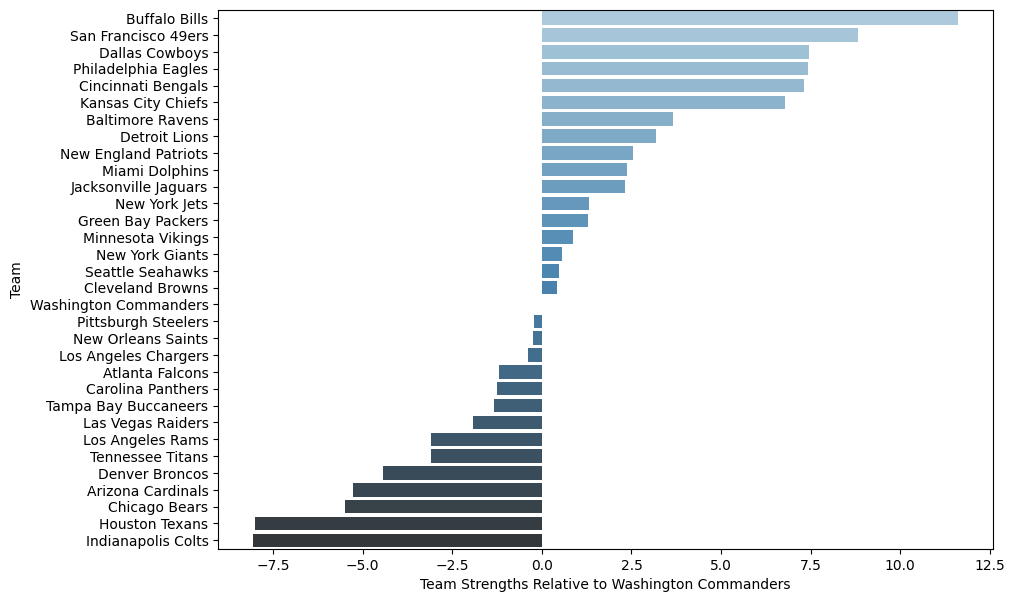

In [ ]:
plt.figure(figsize=(10,7))
color_palette = sns.color_palette('Blues_d', len(df_strengths))
sns.barplot(df_strengths.sort_values('Strength_1',ascending=False), y='Team', x='Strength_1',orient='h', palette=color_palette)
plt.xlabel('Team Strengths Relative to Washington Commanders')

<ipython-input-66-ed2372b427e9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_strengths.sort_values('Strength_2',ascending=False), y='Team', x='Strength_2',orient='h', palette=color_palette)


Text(0.5, 0, 'Team Strengths Relative to League Average')

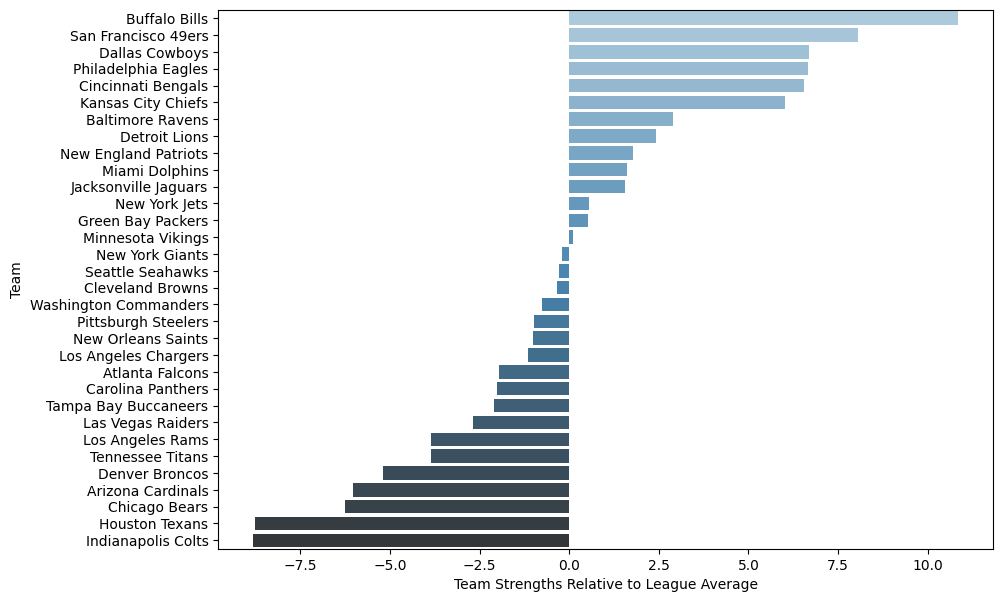

In [ ]:
plt.figure(figsize=(10,7))
color_palette = sns.color_palette('Blues_d', len(df_strengths))
sns.barplot(df_strengths.sort_values('Strength_2',ascending=False), y='Team', x='Strength_2',orient='h', palette=color_palette)
plt.xlabel('Team Strengths Relative to League Average')

## Because we are using this model for inference, we need to check its assumptions.

Text(0.5, 0, 'Predicted Score Differential')

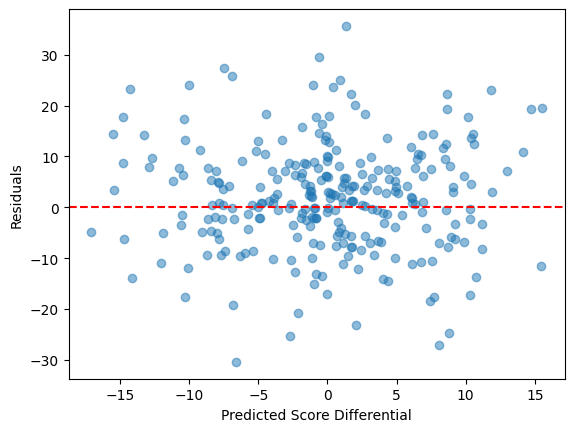

In [ ]:
plt.scatter(model2.fittedvalues, model2.resid, alpha=.5)
plt.axhline(y=0, color='red', linestyle='dashed')
plt.ylabel('Residuals')
plt.xlabel('Predicted Score Differential')

- We see a random scattering of points without any obvious patterns.
- This checks off the following assumptions:
  - Constant variance
  - Linearity
  - Independent errors


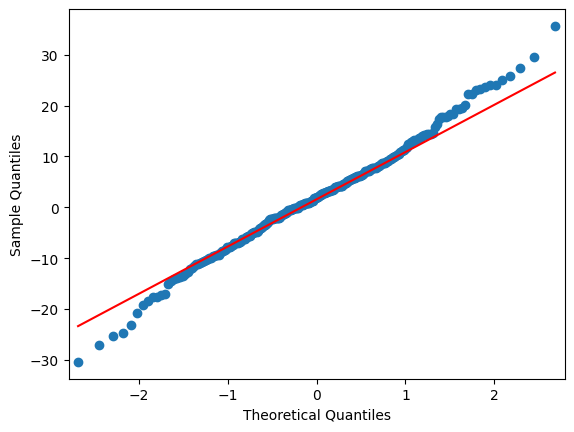

In [ ]:
sm.qqplot(model2.resid, line='q'); # add semi-colon to prevent duplicate plots

- The tails are veering off somewhat from what would be considered normal.

<Axes: ylabel='Count'>

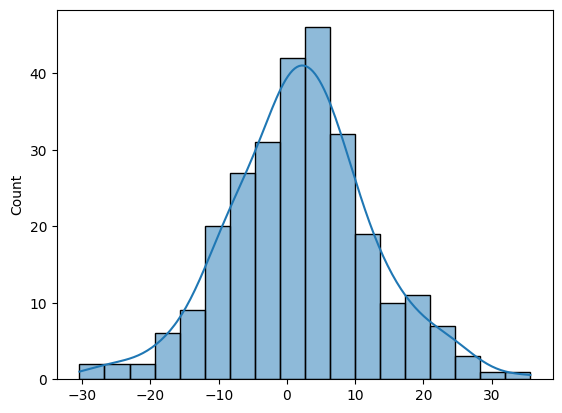

In [ ]:
sns.histplot(model2.resid, kde=True)

- Honestly, this looks okay.
- Since the violations in the Q-Q plot are not too bad, I would say our normality assumption is fine.

<ipython-input-70-a31c37e53e89>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


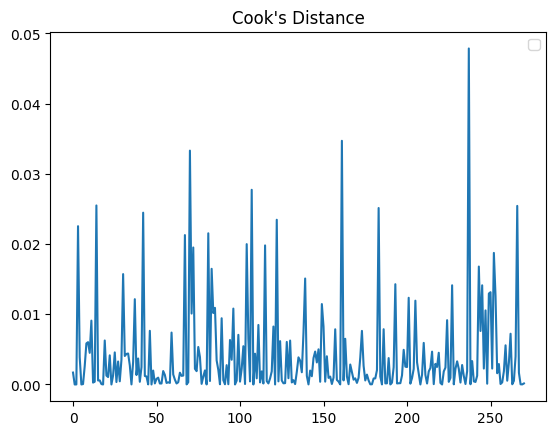

In [ ]:
# Check for highly influential points
influence = model2.get_influence()
plt.plot(influence.cooks_distance[0])

plt.title("Cook's Distance")
plt.legend(loc='best')

- Nothing is even close to 1
- No highly influential points

In [ ]:
VIF(pd.DataFrame(X@W))

,Feature,VIF
0,0,2.034899
1,1,2.156110
2,2,2.024860
3,3,2.089366
4,4,2.036326
5,5,2.156110
6,6,2.089366
7,7,2.143970
8,8,2.274410
9,9,2.032175


- All variance inflation factors are around 2, so there is no severe multicollinearity now that we've addressed it using our constraint.

# Including Covariates (Specifically Home-Field Advantage)

- We will add an additional feature column for home-field advantage.
- It will be defined as the following:
$$X_{HomeAdv} = v = \begin{cases}
0, &
\text{Game played in neutral location} \\
1,  & \text{Otherwise}
\end{cases}$$



In [ ]:
# 5 neutral games this season - had to google these...
# Game 1: 10/2/2022 - Minnesota Vikings vs. New Orleans Saints
# Game 2: 10/9/2022 - New York Giants vs. Green Bay Packers
# Game 3: 10/30/2022 - Denver Broncos vs. Jacksonville Jaguar
# Game 4: 11/13/2022 - Seattle Seahawks vs. Tampa Bay Buccaneers
# Game 5: 11/21/2022 - San Francisco 49ers vs. Arizona Cardinals

In [13]:
# Obtain indices of rows for these particular games
idx1 = nfl[(nfl['Date']=='10/2/22') & (nfl['home_team']=='New Orleans Saints')].index.values[0]
idx2 = nfl[(nfl['Date']=='10/9/22') & (nfl['home_team']=='Green Bay Packers')].index.values[0]
idx3 = nfl[(nfl['Date']=='10/30/22') & (nfl['home_team']=='Jacksonville Jaguars')].index.values[0]
idx4 = nfl[(nfl['Date']=='11/13/22') & (nfl['home_team']=='Tampa Bay Buccaneers')].index.values[0]
idx5 = nfl[(nfl['Date']=='11/21/22') & (nfl['home_team']=='Arizona Cardinals')].index.values[0]

neutral_game_list = [idx1, idx2, idx3, idx4, idx5]
print(f"Neutral Game Indices: {neutral_game_list}")

Neutral Game Indices: [49, 65, 109, 137, 163]


In [14]:
# Now assign values for the home-advantage column (will add to our design matrix in our next step)
nfl['home_adv'] = 1
nfl.loc[neutral_game_list, 'home_adv'] = 0

In [15]:
nfl.head()

,Week,Day,Date,Time,Winner/tie,home_identifier,Loser/tie,Unnamed: 7,PtsW,PtsL,YdsW,TOW,YdsL,TOL,home_team,away_team,home_score_diff,home_adv
0,1,Thu,9/8/22,8:20PM,Buffalo Bills,@,Los Angeles Rams,boxscore,31,10,413,4,243,3,Los Angeles Rams,Buffalo Bills,-21,1
1,1,Sun,9/11/22,1:00PM,New Orleans Saints,@,Atlanta Falcons,boxscore,27,26,385,1,416,2,Atlanta Falcons,New Orleans Saints,-1,1
2,1,Sun,9/11/22,1:00PM,Cleveland Browns,@,Carolina Panthers,boxscore,26,24,355,0,261,1,Carolina Panthers,Cleveland Browns,-2,1
3,1,Sun,9/11/22,1:00PM,Chicago Bears,NaN,San Francisco 49ers,boxscore,19,10,204,1,331,2,Chicago Bears,San Francisco 49ers,9,1
4,1,Sun,9/11/22,1:00PM,Pittsburgh Steelers,@,Cincinnati Bengals,boxscore,23,20,267,0,432,5,Cincinnati Bengals,Pittsburgh Steelers,-3,1


In [16]:
nfl['home_adv'].value_counts(dropna=False)

,count
home_adv,
1,266
0,5


In [17]:
# Add home-advantage column to design matrix - it will now be the final column
X_h = np.column_stack((X, nfl['home_adv'])) # now has 33 columns = 32 teams + 1 home-adv

In [18]:
X[:5,-5:]

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [19]:
X_h[:5,-5:]

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [20]:
X.shape, X_h.shape

((271, 32), (271, 33))

### With our new design matrix, $X_h$, does perfect multicollinearity still exist?

In [23]:
print(f"Condition Number: {np.linalg.cond(X_h)}")
print(f"Determinant: {np.linalg.det(X_h.T @ X_h)}")
print(f"Eigenvalues: {np.linalg.eigvals(X_h.T @ X_h)}")
print(f"Variance Inflation Factors: {VIF(pd.DataFrame(X_h))}")

Condition Number: 1.816562757811321e+16
Determinant: 7.048938802889736e+24
Eigenvalues: [ 2.66173148e+02 -1.36894237e-15  6.86652442e+00  7.75675591e+00
  9.87368458e+00  1.06393152e+01  1.62393096e+01  1.66311383e+01
  1.73732650e+01  1.98093888e+01  2.00000000e+01  1.99996726e+01
  1.90460166e+01  2.13511736e+01  2.14065159e+01  1.59949724e+01
  1.82707299e+01  1.60000000e+01  1.60000000e+01  1.85763878e+01
  1.79920018e+01  1.80000000e+01  1.80000000e+01  1.85857864e+01
  1.85857864e+01  2.14142136e+01  2.14142136e+01  2.14142136e+01
  2.14142136e+01  1.80000000e+01  1.80000000e+01  1.85857864e+01
  1.85857864e+01]
Variance Inflation Factors:     Feature       VIF
0         0       inf
1         1       inf
2         2       inf
3         3       inf
4         4       inf
5         5       inf
6         6       inf
7         7       inf
8         8       inf
9         9       inf
10       10       inf
11       11       inf
12       12       inf
13       13       inf
14       14     

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


- The condition number is extremely large --> highly numerically unstable --> symptom of severe multicollinearity
- Determinant is extremely large. Theoretically, if there is perfect multicollinearity, the determinant is 0. However, due to computer rounding errors, this won't necessarily show up.
- The second eigenvalue is 0 --> perfect multicollinearity.
- All variance inflation factors are infinite except the home-advantage column --> perfect multicollinearity among team columns.

### Need to deal with this in the exact same way as before.
- Let's use the second constraint type moving forward.
- Need to create a $W$ matrix. Below shows what the matrix would look like in our simple toy example of a 4-team league playing 6 games. The $W$ matrix we use for our real data will simply extrapolate these ideas.
$$W = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
-1 & -1 & -1 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}$$
- The original $W$ matrix from earlier is encoded as the first block-matrix. The added home-advantage parameter needs a block just by itself.
- If this doesn't make sense to you, convince yourself that this is the correct matrix by doing the matrix multiplication of $W \gamma_{-4}$, where
$$\gamma = \begin{pmatrix}
\theta_1 \\
\theta_2 \\
\theta_3 \\
\theta_4 \\
\beta
\end{pmatrix}, \,\, \gamma_{-4} =
\begin{pmatrix}
\theta_1 \\
\theta_2 \\
\theta_3 \\
\beta
\end{pmatrix}$$

Because constructing the $W$ matrix is slightly more involved now, let's just create a function to do it for us.

In [24]:
def create_W(n_teams: int, constraint_type: int, home_adv: bool) -> np.ndarray:

  # Start with Identity Matrix
  W = np.identity(n_teams)

  # Assign -1 to all values in last row
  if constraint_type==1:
    W[-1,:] = 0
  elif constraint_type==2:
    W[-1,:] = -1
  else:
    raise ValueError("Parameter 'constraint_type' only takes values 1 or 2.")

  # Remove last team's column
  W = W[:,:-1]

  # Add block for home-advantage
  if home_adv:
    from scipy.linalg import block_diag
    W = block_diag(W, np.array(1).reshape(1,1))

  return W

In [25]:
W_h= create_W(n_teams=len(teams), constraint_type=2, home_adv=True)

In [26]:
# We expect W to now have 33 rows and 32 columns
W_h.shape

(33, 32)

In [27]:
# First several rows and column look like identity
W_h[:5,:5]

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [28]:
# Last several should include row of -1 and block of 1
W_h[-5:,-5:]

array([[ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [-1., -1., -1., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

### Now, compute OLS estimates of our coefficients (team strengths and home-advantage).

In [29]:
gamma_hat = ols_linear_constraint2(X=X_h, y=y, W=W_h, insert_idx=31).reshape((-1,1)) # insert Commanders coefficient into index 31 (32nd value)

In [30]:
gamma_hat

array([[-6.15436378],
       [-2.134416  ],
       [ 3.14428531],
       [10.92176077],
       [-2.18782251],
       [-6.49878373],
       [ 6.93170098],
       [-0.10423955],
       [ 6.48938575],
       [-5.10907853],
       [ 2.1856232 ],
       [ 0.40634885],
       [-8.55367899],
       [-8.61646026],
       [ 1.86742377],
       [ 6.21298854],
       [-2.49849522],
       [-0.95177806],
       [-4.07653741],
       [ 1.8103234 ],
       [-0.23602854],
       [ 1.99472246],
       [-1.06644278],
       [-0.53718294],
       [ 0.75242013],
       [ 6.4541763 ],
       [-0.74423793],
       [ 7.73255561],
       [-0.63140893],
       [-2.15122854],
       [-3.65617844],
       [-0.99535293],
       [ 2.12592398]])

In [31]:
# Should have 33 estimated coefficients (32 teams + 1 home-advantage)
gamma_hat.shape

(33, 1)

In [32]:
print("Check Constraint Works...")
print(f"Commanders Strength: {gamma_hat[31]}")
print(f"Constraint: {-gamma_hat[:31].sum()}")
print(f"Average Team Strength Should Be 0: {gamma_hat[:32].mean()}")

Check Constraint Works...
Commanders Strength: [-0.99535293]
Constraint: -0.9953529307426692
Average Team Strength Should Be 0: 1.1102230246251565e-16


- Everything appears to be working as expected.

## Reorganize our three sets of team strength estimates
1. Strength 1: Team strengths relative to Washington Commanders (set to 0)
2. Strength 2: Team strengths relative to league average (set to 0)
3. Strength 2 w/ Home-Advantage: Team strengths relative to league average (set to 0) while accounting for home-advantage

In [ ]:
# Add new column of team strength estimates
df_strengths['Strength_2_home_adv'] = gamma_hat[:32]

# Create rankings for each type of estimate
df_strengths['Strength_1_rank'] = df_strengths['Strength_1'].rank(ascending=False)
df_strengths['Strength_2_rank'] = df_strengths['Strength_2'].rank(ascending=False)
df_strengths['Strength_2_home_adv_rank'] = df_strengths['Strength_2_home_adv'].rank(ascending=False)

# Print sorted by new estimates
df_strengths.sort_values('Strength_2_home_adv', ascending=False)

,Team,Strength_1,Strength_2,Strength_2_home_adv,Strength_1_rank,Strength_2_rank,Strength_2_home_adv_rank
3,Buffalo Bills,11.611035,10.847009,10.921761,1.0,1.0,1.0
27,San Francisco 49ers,8.829111,8.065084,7.732556,2.0,2.0,2.0
6,Cincinnati Bengals,7.315276,6.551249,6.931701,5.0,5.0,3.0
8,Dallas Cowboys,7.465656,6.701629,6.489386,3.0,3.0,4.0
25,Philadelphia Eagles,7.432188,6.668161,6.454176,4.0,4.0,5.0
15,Kansas City Chiefs,6.776808,6.012781,6.212989,6.0,6.0,6.0
2,Baltimore Ravens,3.663575,2.899548,3.144285,7.0,7.0,7.0
10,Detroit Lions,3.188523,2.424496,2.185623,8.0,8.0,8.0
21,New England Patriots,2.550988,1.786961,1.994722,9.0,9.0,9.0
14,Jacksonville Jaguars,2.316908,1.552881,1.867424,11.0,11.0,10.0


- Things to notice:
  - Ranks of the first two types of estimates are the same. Remember that while the constraints produced different numerical estimates, the **relative differences** remained the same.
  - We can see changes between the first two types of estimates and the last one accounting for home-advantage.
  - Originally, the Cincinnati Bengals were ranked 5th best team in the league. However, once we account for home-field advantage, they move up to the 3rd best team in the league. In other words, their relative abilities were initially being underestimated.

### How did the numerical values of team strength change?

In [ ]:
df_strengths['diff_home_adv'] = df_strengths['Strength_2_home_adv'] - df_strengths['Strength_2']

<ipython-input-92-196e2be96dab>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_strengths.sort_values('diff_home_adv',ascending=False), y='Team', x='diff_home_adv',orient='h', palette=color_palette)


Text(0.5, 0, 'Differences in Estimated Team Strengths (Home-Adv vs None)')

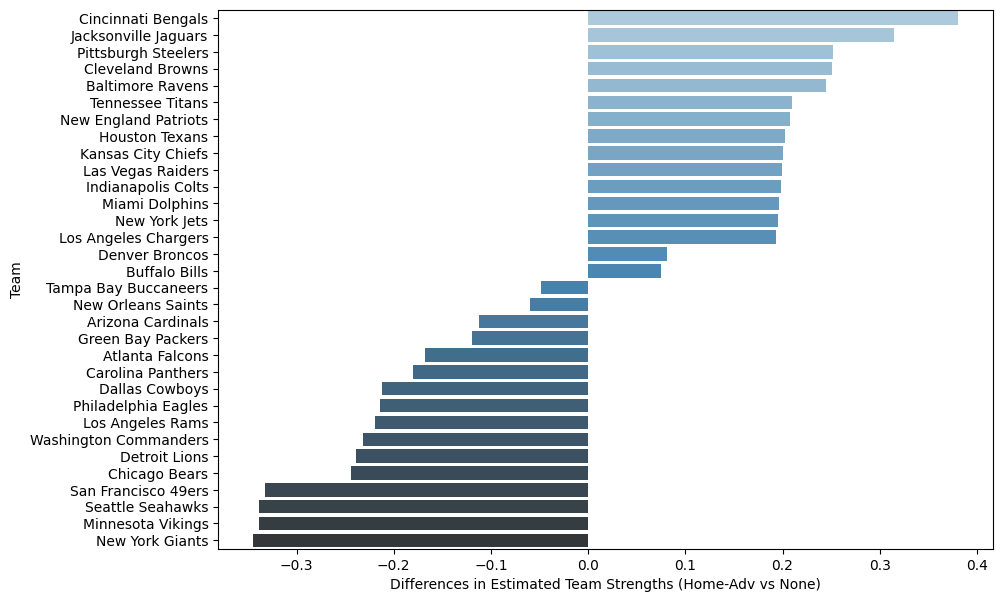

In [ ]:
plt.figure(figsize=(10,7))
color_palette = sns.color_palette('Blues_d', len(df_strengths))
sns.barplot(df_strengths.sort_values('diff_home_adv',ascending=False), y='Team', x='diff_home_adv',orient='h', palette=color_palette)
plt.xlabel('Differences in Estimated Team Strengths (Home-Adv vs None)')

- Numerical changes are relatively small
- Bengals had largest positive change and Giants had largest negative change after accounting for home-advantage.
- Positive values suggest that without accounting for home-advantage, playing away was "hiding" good team abilities.
- Negative values suggest that without accounting for home-advantage, playing home was "hiding" bad team abilities.

## Organize our team strength estimates into a table that also includes the corresponding standard errors
1. Compute $\hat{\sigma}^2$
2. Compute the variance-covariance matrix $\hat{Var}(\hat{\gamma}) = \hat{\sigma}^2 W Z^{*^\top}Z^* W^\top$
3. Compute standard errors $se(\hat{\gamma})$
4. Organize into a dataframe

In [ ]:
def residual_variance(p: int, X: np.ndarray, y: np.ndarray, param_ests: np.ndarray) -> np.ndarray:
  """Compute estimated variance of errors, sigma^2"""
  N = len(X) # number of games, p = # estimated parameters

  return 1/(N-p) * (y-X@param_ests).T @ (y-X@param_ests)

def vcov(W: np.ndarray, X: np.ndarray, y: np.ndarray, p: int, param_ests: np.ndarray) -> np.ndarray:
  """Compute estimated variance-covariance matrix of coefficients"""
  sigma2 = residual_variance(p=p, X=X, y=y, param_ests=np.array(param_ests).reshape((-1,1)))
  X_star = X @ W
  var_param_hat = sigma2 * np.linalg.inv(X_star.T @ X_star)

  return W @ var_param_hat @ W.T


In [ ]:
gamma_hat.shape

(33, 1)

In [ ]:
sigma_2 = residual_variance(p=32, X=X_h, y=y, param_ests=gamma_hat)
sigma_2, np.sqrt(sigma_2)

(array([[122.70511594]]), array([[11.07723413]]))

In [ ]:
vcov_params = vcov(W=W_h, X=X_h, y=y, p=32, param_ests=gamma_hat)
print(vcov_params.shape)

(33, 33)


In [ ]:
vcov_params[:5,:5]

array([[ 7.34520102,  0.25075987, -0.56300556, -0.67071532,  0.25089507],
       [ 0.25075987,  7.35197742,  0.169177  , -0.63620892,  0.83935851],
       [-0.56300556,  0.169177  ,  7.31387325,  0.12489665,  0.20645669],
       [-0.67071532, -0.63620892,  0.12489665,  7.76954468, -0.63629899],
       [ 0.25089507,  0.83935851,  0.20645669, -0.63629899,  7.35239667]])

In [ ]:
vcov_params[-5:,-5:]

array([[ 7.35574883,  0.25051482, -0.65322489, -0.67515595, -0.07449431],
       [ 0.25051482,  7.34951896, -0.76587689, -0.67241352, -0.01064966],
       [-0.65322489, -0.76587689,  7.33862563,  0.22441757,  0.04618921],
       [-0.67515595, -0.67241352,  0.22441757,  7.34944033, -0.0509476 ],
       [-0.07449431, -0.01064966,  0.04618921, -0.0509476 ,  0.46821645]])

In [ ]:
# We will mostly care about the diagonals
param_std_errors = np.sqrt(np.diag(vcov_params)) # these are the standard errors of all 33 coefficients
param_std_errors

array([2.71020313, 2.71145301, 2.70441736, 2.7873903 , 2.71153032,
       2.71204866, 2.78997508, 2.70447437, 2.71088948, 2.70827281,
       2.71200282, 2.71122702, 2.70893444, 2.7089013 , 2.7100402 ,
       2.70891521, 2.7089121 , 2.70886425, 2.71094905, 2.70400634,
       2.71310353, 2.70409687, 2.71098157, 2.7122293 , 2.70400369,
       2.71083757, 2.70448419, 2.71207522, 2.71214838, 2.71099962,
       2.70898978, 2.71098512, 0.68426344])

- Notice the final one is unlike the rest of them --> home-advantage standard error.

In [ ]:
# Create a dataframe that lists all the team strengths, their standard errors, and the corresponding values for home advantange, and estimated error standard deviation
df_ests = pd.DataFrame(columns=['Team', 'Parameter Estimates', 'Standard Errors'])

# Place Teams in Alphabetical Order
df_ests['Team'] = teams

# Add the coefficient estimates and standard errors (the last coefficient and standard error is our home adv)
df_ests['Parameter Estimates'] = gamma_hat[:-1]
df_ests['Standard Errors'] = param_std_errors[:-1]
df_ests_sort = df_ests.sort_values('Parameter Estimates', ascending=False)

# Add the bottom of the dataframe to incorporate home advantage and estimated error standard deviation
df_add = pd.DataFrame(columns=['Team','Parameter Estimates','Standard Errors'])
df_add['Team'] = ['Home-Field Adv', 'Sigma']
df_add['Parameter Estimates'] = [gamma_hat[-1][0], np.sqrt(sigma_2)[0][0]]
df_add['Standard Errors'] = [param_std_errors[-1], np.nan]

# Concatenate everything together
df_ests_sort = pd.concat((df_ests_sort, df_add), axis=0)
df_ests_full = df_ests_sort.copy()

# Round for presentation
df_ests_sort['Parameter Estimates'] = np.round(df_ests_sort['Parameter Estimates'],2)
df_ests_sort['Standard Errors'] = np.round(df_ests_sort['Standard Errors'],2)

In [ ]:
df_ests_sort

,Team,Parameter Estimates,Standard Errors
3,Buffalo Bills,10.92,2.79
27,San Francisco 49ers,7.73,2.71
6,Cincinnati Bengals,6.93,2.79
8,Dallas Cowboys,6.49,2.71
25,Philadelphia Eagles,6.45,2.71
15,Kansas City Chiefs,6.21,2.71
2,Baltimore Ravens,3.14,2.70
10,Detroit Lions,2.19,2.71
21,New England Patriots,1.99,2.70
14,Jacksonville Jaguars,1.87,2.71


### Make in-sample predictions with our `numpy` estimates

In [ ]:
y_pred = X_h @ gamma_hat
res = y - y_pred
rmse = np.mean(res**2)**.5
print(f"In-Sample RMSE: {rmse: .2f}")

In-Sample RMSE:  10.40


- On average, our score differential predictions are off by 10 to 11 points.

### Let's do all of the above in `statsmodels`

In [ ]:
model2_home_adv = sm.OLS(y, exog=X_h @ W_h).fit()
xnames = list(teams)[:-1]+['home_adv']
print(model2_home_adv.summary(xname=xnames))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.305
Model:                            OLS   Adj. R-squared (uncentered):              0.212
Method:                 Least Squares   F-statistic:                              3.285
Date:                Thu, 06 Feb 2025   Prob (F-statistic):                    9.08e-08
Time:                        02:28:39   Log-Likelihood:                         -1019.2
No. Observations:                 271   AIC:                                      2102.
Df Residuals:                     239   BIC:                                      2218.
Df Model:                          32                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

- Note that the individual coefficient standard errors are automatically output for us in the table above.

In [ ]:
# Alertaively, we can directly access the variance-covariance matrix in statsmodels
np.sqrt(np.diag(model2_home_adv.cov_params()))

array([2.71020313, 2.71145301, 2.70441736, 2.7873903 , 2.71153032,
       2.71204866, 2.78997508, 2.70447437, 2.71088948, 2.70827281,
       2.71200282, 2.71122702, 2.70893444, 2.7089013 , 2.7100402 ,
       2.70891521, 2.7089121 , 2.70886425, 2.71094905, 2.70400634,
       2.71310353, 2.70409687, 2.71098157, 2.7122293 , 2.70400369,
       2.71083757, 2.70448419, 2.71207522, 2.71214838, 2.71099962,
       2.70898978, 0.68426344])

- Get same results as above!

# What else can we do with all this information??

## Computing a 95% confidence interval for the Eagles team strength

In [ ]:
from scipy.stats import t

# degrees of freedom = N - p (where p = number of parameters estimated)
N = len(y) # number of games
p = 32 # number of parameters estimated = home advantage(1) + team strengths (31), note commanders is not estimated per constraint
1-t.cdf(3.13, len(y)-32)

0.0009827751779553084

In [ ]:
t_crit = t.ppf(.975, len(y)-32) # 97.5 percentile of t-distribution with N-p degrees of preedom
t_crit

1.9699394059160156

In [ ]:
# Check the 95% confidence interval for the Eagles' estimated team strength, also in final column of statsmodels output
ci_l = 6.4542-t_crit*2.711
ci_u = 6.4542+t_crit*2.711
print(f"95% Confidence Interval for the Philadelphia Eagles Estimated Team Stength: ({np.round(ci_l,2)}, {np.round(ci_u,2)})")


95% Confidence Interval for the Philadelphia Eagles Estimated Team Stength: (1.11, 11.79)


## What else can we do?

In [ ]:
# Find Covariance of estimated parameters for some examples
# Buffalo Bills vs. Philadelphia Eagles
# Buffalo Bills vs. Atlanta Falcons
bills_idx = np.where(teams=='Buffalo Bills')[0][0] # 3
eagles_idx = np.where(teams=='Philadelphia Eagles')[0][0] # 25
falcons_idx = np.where(teams=='Atlanta Falcons')[0][0] # 1
SF_idx = np.where(teams=='San Francisco 49ers')[0][0] # 27

In [ ]:
# Bills vs. Eagles
print(f"Estimated Covariance Between Bills and Eagles: {vcov_params[bills_idx, eagles_idx]}")
print(f"Check: {vcov_params[eagles_idx, bills_idx]}")

# Bills vs. Falcons
print(f"Estimated Covariance Between Bills and Falcons: {vcov_params[bills_idx, falcons_idx]}")

# Eagles vs. 49ers
print(f"Estimated Covariance Between 49ers and Eages: {vcov_params[SF_idx, eagles_idx]}")

Estimated Covariance Between Bills and Eagles: -0.5557070249392521
Check: -0.5557070249392507
Estimated Covariance Between Bills and Falcons: -0.6362089166340094
Estimated Covariance Between 49ers and Eages: -0.6758902031801015


In [ ]:
df_eagles_cov = pd.DataFrame(columns=['Team','Covariance'])
df_eagles_cov['Team'] = teams
df_eagles_cov['Covariance'] = vcov_params[eagles_idx, :-1]

df_eagles_cov

,Team,Covariance
0,Arizona Cardinals,-0.334895
1,Atlanta Falcons,-0.669829
2,Baltimore Ravens,-0.669161
3,Buffalo Bills,-0.555707
4,Carolina Panthers,-0.669571
5,Chicago Bears,0.254211
6,Cincinnati Bengals,-0.678280
7,Cleveland Browns,-0.669294
8,Dallas Cowboys,0.835474
9,Denver Broncos,-0.647663


## Sports Betting Example Calculations

In [ ]:
from scipy.stats import norm

Text(0.5, 0, 'Score Differential (y)')

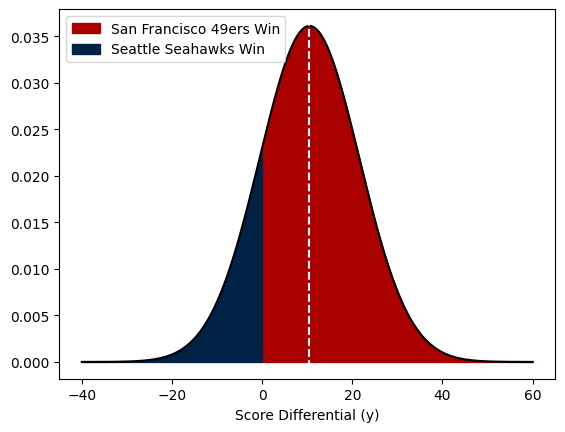

In [ ]:
x = np.linspace(-40,60,1000)

phi = norm.pdf(x=x, loc=10.49, scale=11.05)

plt.plot(x, phi, color='black')
plt.fill_between(x, phi, where=(x > 0), color='#AA0000', label='San Francisco 49ers Win')
plt.fill_between(x, phi, where=(x < 0), color='#002244', label='Seattle Seahawks Win')
plt.axvline(x=10.49, color='white', linestyle='dashed')
plt.legend(loc='best')
plt.xlabel('Score Differential (y)')

Text(0.5, 0, 'Score Differential (y)')

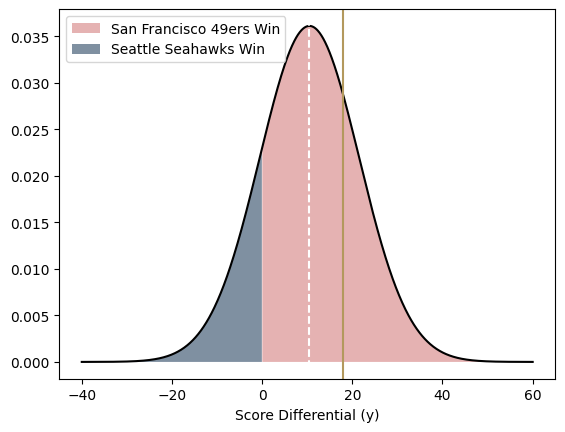

In [ ]:
plt.plot(x, phi, color='black')
plt.fill_between(x, phi, where=(x > 0), color='#AA0000', alpha=.3, label='San Francisco 49ers Win', edgecolor='none')
plt.fill_between(x, phi, where=(x <= 0), color='#002244', alpha=.5, label='Seattle Seahawks Win', edgecolor='none')
plt.axvline(x=10.49, color='white', linestyle='dashed')
plt.axvline(x=18, color='#B3995D')

plt.legend(loc='best')
plt.xlabel('Score Differential (y)')


# Playoff Matchup Predicted Probabilities
$$P(\text{Home Wins}) = P(y > 0) = 1-P(y \le 0)$$ where $y \sim N(\theta_H - \theta_A + \beta_v, \sigma^2)$

In [ ]:
# Jaguars vs Chargers
1-norm.cdf(x=0, loc=1.87-(-.95)+2.13, scale=11.05)

0.6729103391160278

In [ ]:
# Bills vs Dolphins
1-norm.cdf(x=0, loc=10.92-1.81+2.13, scale=11.05)

0.8454695607039385

In [ ]:
# Vikings vs Giants
1-norm.cdf(x=0, loc=-.24-(-.54)+2.13, scale=11.05)

0.5870291821382829

In [ ]:
# Bucs vs Cowboys
1-norm.cdf(x=0, loc=-2.15-(6.49)+2.13, scale=11.05)

0.2778835901650757

In [ ]:
# Chiefs vs. Jaguars
1-norm.cdf(x=0, loc=6.21-1.87+2.13, scale=11.05)

0.7209010603409186

In [ ]:
# Eagles vs Giants
1-norm.cdf(x=0, loc=6.45-(-.54)+2.13, scale=11.05)

0.7954105259696069

In [ ]:
# Bills vs Bengals
1-norm.cdf(x=0, loc=10.92-6.93+2.13, scale=11.05)

0.710157930663181

In [ ]:
# 49ers vs Cowboys
1-norm.cdf(x=0, loc=7.73-6.49+2.13, scale=11.05)

0.6198083081678513

In [ ]:
# Eagles vs 49ers
1-norm.cdf(x=0, loc=6.45-7.74+2.13, scale=11.05)

0.5302976507468372

In [ ]:
# Chiefs vs Bengals
1-norm.cdf(x=0, loc=6.21-6.93+2.13, scale=11.05)

0.5507679506465969

In [ ]:
# Chiefs vs Eagles - Neutral Location
1-norm.cdf(x=0, loc=6.21-6.45, scale=11.05)

0.4913358714904523

In [ ]:
df_ests_full

,Team,Parameter Estimates,Standard Errors
3,Buffalo Bills,10.921761,2.787390
27,San Francisco 49ers,7.732556,2.712075
6,Cincinnati Bengals,6.931701,2.789975
8,Dallas Cowboys,6.489386,2.710889
25,Philadelphia Eagles,6.454176,2.710838
15,Kansas City Chiefs,6.212989,2.708915
2,Baltimore Ravens,3.144285,2.704417
10,Detroit Lions,2.185623,2.712003
21,New England Patriots,1.994722,2.704097
14,Jacksonville Jaguars,1.867424,2.710040


In [ ]:
# To use for simulation of the next season
df_ests_full.to_csv("../drive/MyDrive/data/Football/NFL_estimated_team_strengths_2022_2023.csv", index=False)